In [1]:
# Load packages
import time
from utilities import *

### Remark 5.8. Bounding risk premia

- Set objective function to be $g_1(x)+\zeta g_2(x)$ and vary $\xi$ to hit the relative entropy constraint for alternative $\zeta$ with no sign restrictions on $\zeta$.


- Compute 
$$
\log \int \mathbb{E}\left[N_1^*g_1(X_1)\mid \mathfrak{I}_0\right]d Q_0^* - \log \int \mathbb{E}\left[N_1^*g_2(X_1)\mid \mathfrak{I}_0\right]d Q_0^*
$$
which will depend on $\zeta$.


- Minimize over $\zeta$.


- Perform this for $g_1(X_1)=R_1^w$ and $g_2(X_1)=R_1^f$ to compute a lower bound on the proportional risk premium.

In [3]:
def risk_premia(ζ,lower=True,ξ_tol=1e-7):
    # Initialize the solver
    solver = InterDivConstraint(tol=1e-9,max_iter=1000)

    # Define g(X) = Rw + ζ*Rf
    g1 = np.exp(solver.log_Rw)
    g2 = (solver.X[:,0]+1.)*np.exp(solver.log_Rw)

    solver.g = g1 + ζ*g2

    # Find ξ that corresponds to 120% min RE
    x_min_RE = 1.2
    ξ = solver.find_ξ(x_min_RE=x_min_RE,lower=lower,tol=ξ_tol,max_iter=100)

    # Solve models with the chosen ξ
    result = solver.iterate(ξ,lower=lower)

    # Calculate risk premia
    # Term 1
    moment_bound_cond_g1 = []
    for i in np.arange(1,solver.n_states+1,1):
        temp = np.mean(result['N'][solver.pd_lag_indicator[:,i-1]]*g1[solver.pd_lag_indicator[:,i-1]])
        moment_bound_cond_g1.append(temp)
    moment_bound_cond_g1 = np.array(moment_bound_cond_g1)
    moment_bound_g1 = moment_bound_cond_g1@result['π_tilde']
    
    # Term 2
    moment_bound_cond_g2 = []
    for i in np.arange(1,solver.n_states+1,1):
        temp = np.mean(result['N'][solver.pd_lag_indicator[:,i-1]]*g2[solver.pd_lag_indicator[:,i-1]])
        moment_bound_cond_g2.append(temp)
    moment_bound_cond_g2 = np.array(moment_bound_cond_g2)
    moment_bound_g2 = moment_bound_cond_g2@result['π_tilde']
    
    # Combine term 1 and term 2
    risk_premia = np.log(moment_bound_g1) - np.log(moment_bound_g2)
    
    return risk_premia

In [4]:
# Upper bound
# Count time
time_start = time.time() 

# Use a grid for ζ
ζ_min = -1.1
ζ_max = -0.9
ζ_points = 200
ζ_step = (ζ_max-ζ_min)/ζ_points
ζ_grid = np.arange(ζ_min,ζ_max,ζ_step)
risk_premia_array = np.zeros_like(ζ_grid)

# Do computation for each ζ
for i in range(len(ζ_grid)):
    if i%10 == 0:
        print('--- processing: #%s ---' % i)
    ζ = ζ_grid[i]
    risk_premia_array[i] = risk_premia(ζ,lower=False,ξ_tol=1e-7)
print('--- finished ---')

# Print out the time spent
time_spent = round(time.time()-time_start,4)
print("Time spent: %s seconds ---" % (time_spent))

--- processing: #0 ---
--- processing: #10 ---
--- processing: #20 ---
--- processing: #30 ---
--- processing: #40 ---
--- processing: #50 ---
--- processing: #60 ---
--- processing: #70 ---
--- processing: #80 ---
--- processing: #90 ---
--- processing: #100 ---
--- processing: #110 ---
--- processing: #120 ---
--- processing: #130 ---
--- processing: #140 ---
--- processing: #150 ---
--- processing: #160 ---
--- processing: #170 ---
--- processing: #180 ---
--- processing: #190 ---
--- processing: #200 ---
--- finished ---
Time spent: 1997.9438 seconds ---


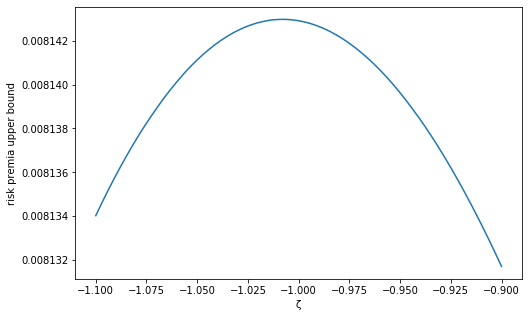

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)

plt.plot(ζ_grid,risk_premia_array)
plt.xlabel('ζ')
plt.ylabel('risk premia upper bound')
plt.savefig('risk_premia_plot_20%',dpi=100)
plt.show()

In [31]:
risk_premia_optimal = risk_premia_array.max()
ζ_optimal = ζ_grid[risk_premia_array == risk_premia_optimal][0]
print('Optimal ζ: %s' % np.round(ζ_optimal,3))
print('Upper bound on the proportional risk premium: %s' % risk_premia_optimal)

Optimal ζ: -1.007
Upper bound on the proportional risk premium: 0.00814297373755317


In [29]:
np.sign(0.5)

1.0